## Regressão Logistica  MG



In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import collections
import numpy as np
import re
from functions import logistic_reg,xg_boost
import seaborn as sns
import matplotlib.pyplot as plt
import pickle



In [2]:
def normalize(df_series):
  return   df_series / df_series.max()


In [3]:
data = pd.read_csv('notificacoes-covid19-mg.csv',sep=';',encoding='iso-8859-1')
data_original = data
print('Colunas: {}'.format(data.columns.values))

data = data.loc[data['EVOLUCAO'] !='EM ACOMPANHAMENTO']

data = data.loc[data['INTERNACAO'] !='nao_informado']

data = data.drop(columns=['ID','CONTADOR','DATA_NOTIFICACAO','DATA_ATUALIZACAO','MUNICIPIO_RESIDENCIA_COD','EVOLUCAO'])

data.head()

data['IDADE'] = normalize(data['IDADE'])

Colunas: ['ID' 'CONTADOR' 'DATA_NOTIFICACAO' 'CLASSIFICACAO_CASO' 'SEXO' 'IDADE'
 'FAIXA_ETARIA' 'MUNICIPIO_RESIDENCIA_COD' 'MUNICIPIO_RESIDENCIA'
 'COMORBIDADE' 'EVOLUCAO' 'INTERNACAO' 'UTI' 'DATA_ATUALIZACAO']


In [4]:
#Trabalho com colunas que possuem 'Yes' e 'No'

columns = ('INTERNACAO','UTI')
for x in columns:
  data[x] = data[x].map(dict(sim=1, nao=0))


#trabalho com colunas que possuem valores em string
columns_dummies = ['CLASSIFICACAO_CASO','SEXO','FAIXA_ETARIA','COMORBIDADE','MUNICIPIO_RESIDENCIA']
df_dummies = pd.DataFrame()
for x in columns_dummies:
  df_dummies = pd.concat([df_dummies,pd.get_dummies(data[x])],axis=1)
data = pd.concat([data,df_dummies],axis=1)


#drop columns que foram criados os dummies 
columns_to_drop = columns_dummies 
data = data.drop(columns=columns_to_drop)


#transformar valores que faltam em 0
data = data.fillna(0)

# drop UTI 
data = data.drop(columns=['UTI'])


In [5]:
#distribuição de 0 e 1
y= 'INTERNACAO'
porc = pd.DataFrame(data[y].value_counts())
porc['porcentagem'] = porc[y] / np.sum(data[y].value_counts().values)
porc

,INTERNACAO,porcentagem
0,9961,0.813408
1,2285,0.186592


In [6]:
#logistic_reg(data,y)


# Regressão RS


In [7]:
dates = ['DATA_SINTOMAS','DATA_CONFIRMACAO','DATA_EVOLUCAO','DATA_EVOLUCAO_ESTIMADA']
data_rs = pd.read_csv('20200702.csv',sep=';',encoding='iso-8859-1',parse_dates=dates)
data_original_rs = data_rs 
print(data_rs.columns)

not_dates= [x for x in list(data_rs.columns) if x not in dates]

len(data_rs.columns)

Index(['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID', 'SEXO',
       'FAIXAETARIA', 'CRITERIO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS',
       'DATA_EVOLUCAO', 'EVOLUCAO', 'HOSPITALIZACAO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'OUTROS', 'COMORBIDADES', 'DATA_INCLUSAO_OBITO',
       'DATA_EVOLUCAO_ESTIMADA', 'RACA_COR'],
      dtype='object')


21

In [8]:
data_rs = data_rs.drop(columns=['COD_IBGE','REGIAO_COVID','COD_REGIAO_COVID','DATA_CONFIRMACAO','DATA_SINTOMAS','DATA_EVOLUCAO','RACA_COR','DATA_EVOLUCAO_ESTIMADA',
                                'DATA_INCLUSAO_OBITO'])
print(len(data_rs.columns))

columns = ('HOSPITALIZACAO','FEBRE','TOSSE','GARGANTA','DISPNEIA','OUTROS')
for x in columns:
    data_rs[x] = data_rs[x].map(dict(sim=1, nao=0,SIM=1,NAO=0,Sim=1,Nao=0))



#trabalho com colunas que possuem valores em string
columns_dummies = ['MUNICIPIO','SEXO','FAIXAETARIA','CRITERIO']
df_dummies = pd.DataFrame()
for x in columns_dummies:
    df_dummies = pd.concat([df_dummies,pd.get_dummies(data_rs[x])],axis=1)
data_rs = pd.concat([data_rs,df_dummies],axis=1)


#morbidades dummies
morb_dummies = data_rs['COMORBIDADES'].str.get_dummies(sep=',')

data_rs = pd.concat([data_rs,morb_dummies],axis=1)


data_rs = data_rs.fillna(-9999)



#drop columns que foram criados os dummies e variaveis não utilziadas
columns_to_drop = columns_dummies + ["COMORBIDADES"]
data_rs = data_rs.drop(columns=columns_to_drop)



regex = re.compile(r"\[|\]|<", re.IGNORECASE)
data_rs.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data_rs.columns.values]
print(len(data_rs.columns))
print(len(data_rs))
data_rs = data_rs.loc[data_rs['EVOLUCAO'] != 'EM ACOMPANHAMENTO']
data_rs = data_rs.drop(columns=['EVOLUCAO'])

len(data_rs)

12
480
28171


23931

In [9]:
with open('cols.pkl', 'wb') as f:
    pickle.dump(data_rs.columns.values, f)


In [10]:
#distribuição de 0 e 1
y= 'HOSPITALIZACAO'
porc = pd.DataFrame(data_rs[y].value_counts())
porc['porcentagem'] = porc[y] / np.sum(data_rs[y].value_counts().values)
porc

,HOSPITALIZACAO,porcentagem
0,21161,0.884251
1,2770,0.115749


In [11]:
logistic_reg(data_rs,y)

Numero de 0: 3242, %: 0.9030640668523677 
Numero de 1: 348, %: 0.09693593314763231

Accuracy: 96.91%
Resultado
Correto Negativo    3154
Correto Positivo     325
Falso Negativo        88
Falso Positivo        23
Name: predict, dtype: int64

Taxa de Acerto Negativos:97.3% 
Taxa de Acerto Positivos: 93.4%


#XGBoost RS


In [12]:
xg_boost(data_rs,y)


Numero de 0: 3230, %: 0.8997214484679665 
Numero de 1: 360, %: 0.10027855153203342

Accuracy: 96.91%
Resultado
Correto Negativo    3148
Correto Positivo     331
Falso Negativo        82
Falso Positivo        29
Name: predict, dtype: int64

Taxa de Acerto Negativos:97.5% 
Taxa de Acerto Positivos: 91.9%


# RS Data Exploration

In [13]:
data_original_rs.head()
print(data_original_rs.columns)


Index(['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID', 'SEXO',
       'FAIXAETARIA', 'CRITERIO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS',
       'DATA_EVOLUCAO', 'EVOLUCAO', 'HOSPITALIZACAO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'OUTROS', 'COMORBIDADES', 'DATA_INCLUSAO_OBITO',
       'DATA_EVOLUCAO_ESTIMADA', 'RACA_COR'],
      dtype='object')


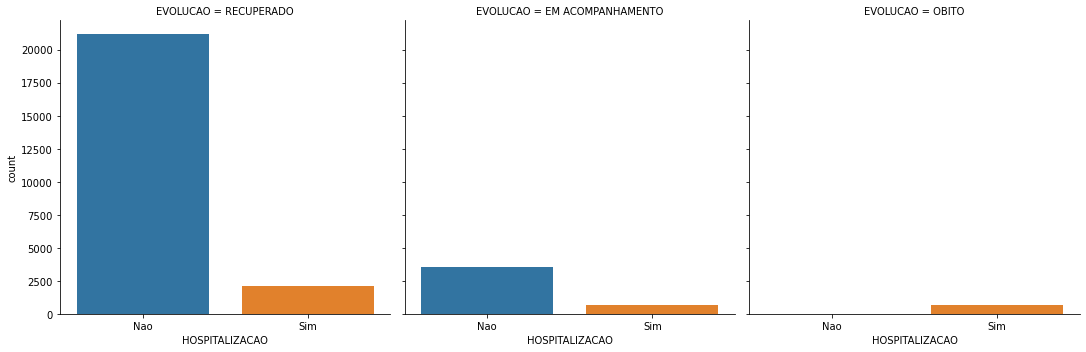

In [14]:
sns.catplot(data=data_original_rs,x='HOSPITALIZACAO',kind="count",col='EVOLUCAO')



In [15]:
data_original_rs.groupby('HOSPITALIZACAO').count()


,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,EVOLUCAO,FEBRE,TOSSE,GARGANTA,DISPNEIA,OUTROS,COMORBIDADES,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR
HOSPITALIZACAO,,,,,,,,,,,,,,,,,,,,
Nao,24717,24717,24717,24717,24717,24717,24717,24717,24717,2,24717,24661,24661,24661,24441,24661,2202,2,21159,24717
Sim,3454,3454,3454,3454,3454,3454,3454,3454,3454,2584,3454,3451,3451,3451,3451,3451,2322,634,203,3454
